In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import os

In [2]:
dt_labels = pd.read_csv('./Dataset/Labels.csv')
print(dt_labels.head())
print(dt_labels.shape)

                image  label
0  Img/img001-001.png      0
1  Img/img001-002.png      0
2  Img/img001-003.png      0
3  Img/img001-004.png      0
4  Img/img001-005.png      0
(550, 2)


In [4]:
image_paths = dt_labels['image']
images = []
for filename in os.listdir("./Dataset/Img"):
    img = cv2.imread(os.path.join("./Dataset/Img",filename), 0)
    if img is not None:
        images.append(img)
print("Loaded all images!")
train_X = np.array(images)
train_X = tf.reshape(train_X, (550, 900 * 1200))
train_X = tf.transpose(train_X)
train_X = tf.math.divide(train_X, 255)
print(train_X.shape)
print("All the training set it's ready")

Loaded all images!
(1080000, 550)
All the training set it's ready


In [5]:
train_Y = tf.one_hot(dt_labels['label'], 9)
train_Y = tf.transpose(train_Y)
print(train_Y.shape)

(9, 550)


In [55]:
def initialize_parameters(layers):
    # Define He Initializer for ReLu activations and GlorotNormal for last unit that will be a sigmoid activation
    initializerHe = tf.keras.initializers.HeNormal(seed=1)
    initializerGn = tf.keras.initializers.GlorotNormal(seed=1)
    
    parameters = {}
    dims = len(layers) - 1
    
    for i in range(1, dims):
        parameters["W" + str(i)] = tf.Variable(initializerHe(shape=(layers[i], layers[i-1])))
        parameters["b" + str(i)] = tf.Variable(initializerHe(shape=(layers[i], 1)))

    parameters["W" + str(dims)] = tf.Variable(initializerHe(shape=(layers[dims], layers[dims-1])))
    parameters["b" + str(dims)] = tf.Variable(initializerHe(shape=(layers[dims], 1)))
    
    return parameters

In [14]:
parameters = initialize_parameters([1080000, 10, 9])
print(parameters)

{'W1': <tf.Variable 'Variable:0' shape=(10, 1080000) dtype=float32, numpy=
array([[ 0.06439073, -0.2506563 ,  0.32090592, ...,  0.8629949 ,
         0.49437156, -0.00308718],
       [-0.5990255 ,  0.7162178 ,  0.2655924 , ...,  0.4899503 ,
        -0.01279758, -0.09620333],
       [ 0.14524604, -0.8087496 ,  0.31340772, ..., -0.40917453,
         0.15573189,  0.80618495],
       ...,
       [ 0.27263913, -0.27042505,  0.4345596 , ..., -0.7181348 ,
         0.3809348 ,  0.2617215 ],
       [-0.29920503, -0.60279155, -0.26285815, ..., -0.33375198,
        -0.2870261 , -0.31720936],
       [ 0.36877394, -0.67558473, -0.26388133, ...,  0.14851595,
         0.9928093 , -0.7105205 ]], dtype=float32)>, 'b1': <tf.Variable 'Variable:0' shape=(10, 1) dtype=float32, numpy=
array([[ 0.06439073],
       [-0.2506563 ],
       [ 0.32090592],
       [-0.40106028],
       [-0.46258327],
       [-0.20294088],
       [-0.0193803 ],
       [ 0.23794131],
       [-0.00762046],
       [-0.71328866]], dtype=

In [92]:
def forward_propagation(X, parameters, layers):
    dims = len(layers) - 1
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    Z_temp = tf.math.add(tf.linalg.matmul(W1,X), b1)
    A_temp = tf.keras.activations.relu(Z_temp)
    
    for i in range(2, dims):
        Z_temp = tf.math.add(tf.linalg.matmul(parameters["W" + str(i)],A_temp), parameters["b" + str(i)])
        A_temp = tf.keras.activations.relu(Z_temp)
        
    Z_temp = tf.math.add(tf.linalg.matmul(parameters["W" + str(dims)],A_temp), parameters["b" + str(dims)])
    A_temp = tf.keras.activations.softmax(Z_temp)

    return Z_temp

In [15]:
print(forward_propagation(train_X, parameters, [13, 10, 1]))

tf.Tensor(
[[ -30.359917  -82.569115  -73.53393  ...  -33.573727  -31.25817
   -34.258476]
 [ -53.88803  -102.48489   -79.99532  ...  -51.18746     3.265846
    83.364265]
 [ 214.89783   312.4315    124.74009  ...  210.12125   202.76048
   172.09781 ]
 ...
 [ 456.16364   496.12894   332.47873  ...  387.84183   366.3716
   257.62192 ]
 [-113.918236 -127.340294 -122.1096   ... -185.87344  -177.22052
  -134.04996 ]
 [ 245.8759    166.85211   240.76164  ...  131.73451    60.47762
  -102.7955  ]], shape=(9, 550), dtype=float32)


In [115]:
def compute_cost(predicted_Y, true_Y):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    return cce(true_Y, predicted_Y)

In [116]:
pred = tf.constant([[ 2.4048107,   5.0334096 ],
             [-0.7921977,  -4.1523376 ],
             [ 0.9447198,  -0.46802214],
             [ 1.158121,    3.9810789 ],
             [ 4.768706,    2.3220146 ],
             [ 6.1481323,   3.909829  ]])
true = tf.constant([[ 1,   0 ],
             [1,  1 ],
             [ 0,  0],
             [ 0,    0 ],
             [ 1,    1 ],
             [ 1,   0  ]])
print(compute_cost(pred, true))

tf.Tensor(0.8567131, shape=(), dtype=float32)


In [20]:
def model(X_train, Y_train, learning_rate = 0.0001, num_epochs = 1500, layers = [1], print_cost = True):
    
    # Save all the costs around the training
    costs = []
    
    # Initialize the parameters
    parameters = initialize_parameters(layers)
    trainable_variables = []
    for i in range(1, len(layers)-1):
        trainable_variables.append(parameters["W" + str(i)])
        trainable_variables.append(parameters["b" + str(i)])
    # print(trainable_variables)
    
    # I want to use the Adam optimizer in my model, in my experience, it's very efficient
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    for epoch in range(num_epochs):
        with tf.GradientTape() as tape:
            # Do the fordward propagation
            Z3 = forward_propagation(X_train, parameters, layers)

            # Compute the cost function
            cost = compute_cost(Z3, Y_train)

        grads = tape.gradient(cost, trainable_variables)
        optimizer.apply_gradients(zip(grads, trainable_variables))

        if print_cost == True and epoch % 10 == 0:
            print ("Cost after epoch %i: %f" % (epoch, cost))

        costs.append(cost)
    
    return parameters, costs

Cost after epoch 0: 364.736603
Cost after epoch 10: 346.947388
Cost after epoch 20: 346.799316
Cost after epoch 30: 347.045441
Cost after epoch 40: 347.004669


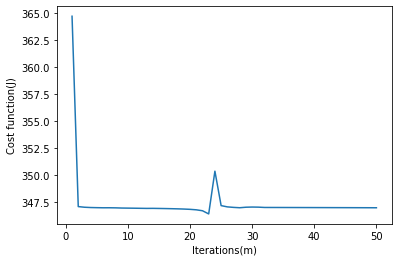

In [117]:
num_epochsTrain = 50 #9500 #4500 #7200
layers_train = [1080000, 25, 18, 9]
parameters, costs = model(train_X, train_Y, learning_rate = 0.01, layers=layers_train , num_epochs = num_epochsTrain)
plt.plot(np.arange(num_epochsTrain)+1, costs)
plt.xlabel("Iterations(m)")
plt.ylabel("Cost function(J)")
plt.show()

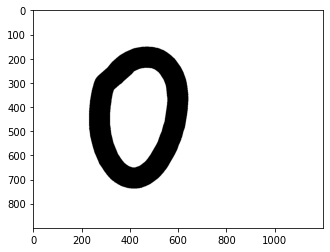

In [34]:
temp4 = train_X[:,0]
temp4 = tf.reshape(temp4,(900, 1200))
plt.gray()
plt.imshow(temp4)

(1080000, 550)
tf.Tensor(
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]], shape=(9, 1), dtype=float32)


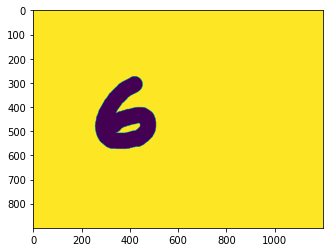

In [125]:
test1 = train_X[:,340]
print(train_X.shape)
#print(tf.reshape(test1,(900, 1200)))
#print(tf.reshape(test1,(900, 1200))[:,450])
#plt.imshow(tf.reshape(test1,(900, 1200))[:,450])
plt.imshow(tf.reshape(test1,(900, 1200)))
test1 = tf.reshape(test1,(1080000,1))
Ztest = forward_propagation(test1, parameters, layers_train)
Ztest = tf.keras.activations.softmax(Ztest)
print((Ztest))